In [14]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
 
import matplotlib.pyplot as plt

from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/trueuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/trueuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

*Посмотрим на наш датасет*

In [2]:
df = pd.read_csv('dataset.csv')
df

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
...,...,...
199995,Conor maynard seamlessly fits old-school r&b h...,False
199996,How to you make holy water? you boil the hell ...,True
199997,How many optometrists does it take to screw in...,True
199998,Mcdonald's will officially kick off all-day br...,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 1.7+ MB


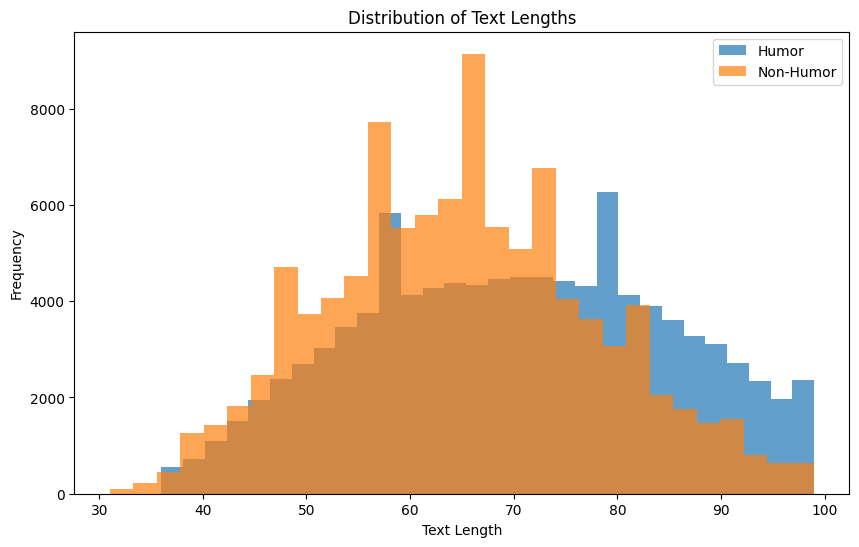

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['humor'] == True]['text'].str.len(), bins=30, alpha=0.7, label='Humor')
plt.hist(df[df['humor'] == False]['text'].str.len(), bins=30, alpha=0.7, label='Non-Humor')
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.legend()
plt.show()

*Возьмем датасет поменьше (чтобы не так долго обучалось), попробуем на нем разные модельки, среди них возьмем самую лучшую и обучим уже на всём датасете*

In [5]:
small_df = df.head(5000)
small_df

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
...,...,...
4995,Why i won’t support medium’s new paid platform,False
4996,What do you call a wandering cave man? a meand...,True
4997,How do you get a fat girl in bed? piece of cake,True
4998,Mary j. blige encourages 'real talk' on new ra...,False


In [6]:
df['humor'] = df['humor'].astype(int)
small_df['humor'] = small_df['humor'].astype(int)

/tmp/ipykernel_24141/399241374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['humor'] = small_df['humor'].astype(int)


array([[<Axes: title={'center': 'humor'}>]], dtype=object)

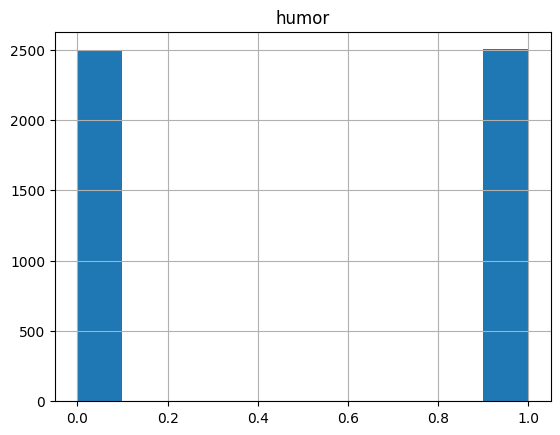

In [7]:
small_df.hist()

array([[<Axes: title={'center': 'humor'}>]], dtype=object)

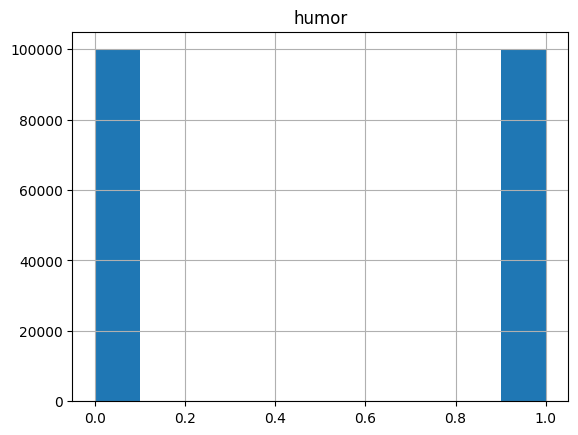

In [8]:
df.hist()

*Дисбаланса классов нет (в маленьком датасете чуть-чуть-чуть больше 1, чем 0, но кажется это совсем не страшно)*

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from nltk.stem.porter import *

In [10]:
train, test = train_test_split(small_df, test_size = 0.25, random_state = 52)

In [11]:
x_train = train['text']
x_test = test['text']

y_train = train['humor']
y_test = test['humor']

*Давайте сначала попробуем вообще ничего не обрабатывать, ради интереса*

In [12]:
from tqdm import tqdm

In [13]:
fit_results = []

for vect in tqdm([CountVectorizer(), TfidfVectorizer()]):
    for model in tqdm([LogisticRegression(), RandomForestClassifier(), CatBoostClassifier(verbose = 500)]):
        pipeline = Pipeline(
            [
                ("vect", vect),
                ("model", model),
            ]
        )
        pipeline.fit(x_train, y_train)
        y_pred = pipeline.predict(x_test)
        
        accuracy_metric = accuracy_score(y_pred, y_test)
        recall_metric = recall_score(y_pred, y_test)
        precision_metric = precision_score(y_pred, y_test)
        f1_metric = f1_score(y_pred, y_test)
        
        fit_results.append(
            {
                'vect': vect.__class__.__name__,
                'model': model.__class__.__name__,
                'accuracy': accuracy_metric,
                'recall': recall_metric,
                'precision': precision_metric,
                'f1': f1_metric,
            }
        )

fit_results = pd.DataFrame(fit_results)
fit_results

 67%|██████████████████████████████               | 2/3 [00:11<00:06,  6.71s/it]

Learning rate set to 0.018115
0:	learn: 0.6855230	total: 248ms	remaining: 4m 7s
500:	learn: 0.3139083	total: 29.6s	remaining: 30.8s



 50%|██████████████████████▌                      | 1/2 [01:07<01:07, 67.53s/it]

999:	learn: 0.2468758	total: 56.5s	remaining: 0us



 67%|██████████████████████████████               | 2/3 [00:06<00:03,  3.69s/it]

Learning rate set to 0.018115
0:	learn: 0.6855522	total: 87.6ms	remaining: 1m 27s
500:	learn: 0.3174990	total: 40.9s	remaining: 42.4s



100%|█████████████████████████████████████████████| 2/2 [03:03<00:00, 91.88s/it]

999:	learn: 0.2370501	total: 1m 49s	remaining: 0us


,vect,model,accuracy,recall,precision,f1
0,CountVectorizer,LogisticRegression,0.9000,0.907251,0.884868,0.895920
1,CountVectorizer,RandomForestClassifier,0.8872,0.868878,0.904605,0.886382
2,CountVectorizer,CatBoostClassifier,0.8752,0.891003,0.847039,0.868465
3,TfidfVectorizer,LogisticRegression,0.9024,0.886943,0.916118,0.901294
4,TfidfVectorizer,RandomForestClassifier,0.8880,0.864486,0.912829,0.888000
5,TfidfVectorizer,CatBoostClassifier,0.8776,0.887564,0.856908,0.871967


*Получилось неплохо. Давайте теперь обработаем*

*Для начала уберем стоп-слова*

In [15]:
def remove_from_text(text: str) -> str:
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(filtered_words)

class RemoveStopWords(BaseEstimator):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return np.array(list(map(lambda x: ''.join(remove_from_text(x)), x)))

In [19]:
pd.DataFrame(x_train)

,0
0,U.s. schools already faced 10 shooting inciden...
1,I sleep better naked...why can't flight attend...
2,"The gop tax scam makes super-rich, richer, wid..."
3,"Zithromax, widely used antibiotic known z-pak,..."
4,How confuse ugly person orange.
...,...
3745,How stop worrying love artificial intelligence
3746,Two ducks walk bar. third duck ducks.
3747,This ancient video kendall kylie jenner lip-sy...
3748,Why russia gassy country? leader putin long time.


In [20]:
x_train = RemoveStopWords().transform(x_train)
x_test = RemoveStopWords().transform(x_test)

In [21]:
pd.DataFrame(x_train)

,0
0,U.s. schools already faced 10 shooting inciden...
1,I sleep better naked...why can't flight attend...
2,"The gop tax scam makes super-rich, richer, wid..."
3,"Zithromax, widely used antibiotic known z-pak,..."
4,How confuse ugly person orange.
...,...
3745,How stop worrying love artificial intelligence
3746,Two ducks walk bar. third duck ducks.
3747,This ancient video kendall kylie jenner lip-sy...
3748,Why russia gassy country? leader putin long time.


In [22]:
from nltk.stem.porter import *

stemmer = PorterStemmer()

In [23]:
class StemmerEng(BaseEstimator):
    def __init__(self):
        self.stemmer = PorterStemmer()
        
    def fit(self, x, y=None):
        return self
    
    def _stem(self, word):
        return self.stemmer.stem(word)
    
    def _transform_text(self, text):
        return ' '.join(map(self._stem, text.split())) 

    def transform(self, x):
        return list(map(self._transform_text, x))

In [24]:
fit_results = []

for vect in tqdm([CountVectorizer(), TfidfVectorizer()]):
    for model in tqdm([LogisticRegression(), RandomForestClassifier(), CatBoostClassifier(verbose = 500)]):
        pipeline = Pipeline(
            [
                ("stem", StemmerEng()),
                ("vect", vect),
                ("model", model),
            ]
        )
        pipeline.fit(x_train, y_train)
        y_pred = pipeline.predict(x_test)
        
        accuracy_metric = accuracy_score(y_pred, y_test)
        recall_metric = recall_score(y_pred, y_test)
        precision_metric = precision_score(y_pred, y_test)
        f1_metric = f1_score(y_pred, y_test)
        
        fit_results.append(
            {
                'vect': vect.__class__.__name__,
                'model': model.__class__.__name__,
                'accuracy': accuracy_metric,
                'recall': recall_metric,
                'precision': precision_metric,
                'f1': f1_metric,
            }
        )

fit_results = pd.DataFrame(fit_results)
fit_results

 67%|██████████████████████████████               | 2/3 [00:11<00:06,  6.33s/it]

Learning rate set to 0.018115
0:	learn: 0.6873053	total: 34ms	remaining: 34s
500:	learn: 0.4062674	total: 16.8s	remaining: 16.9s
999:	learn: 0.3327749	total: 36.2s	remaining: 0us



 67%|██████████████████████████████               | 2/3 [00:09<00:05,  5.30s/it]

Learning rate set to 0.018115
0:	learn: 0.6877127	total: 69.9ms	remaining: 1m 9s
500:	learn: 0.4067833	total: 44.4s	remaining: 46.4s
999:	learn: 0.3223238	total: 1m 23s	remaining: 0us



100%|█████████████████████████████████████████████| 2/2 [02:21<00:00, 70.87s/it]


,vect,model,accuracy,recall,precision,f1
0,CountVectorizer,LogisticRegression,0.8896,0.898305,0.871711,0.884808
1,CountVectorizer,RandomForestClassifier,0.8552,0.873905,0.820724,0.846480
2,CountVectorizer,CatBoostClassifier,0.8440,0.883117,0.782895,0.829991
3,TfidfVectorizer,LogisticRegression,0.8864,0.893581,0.870066,0.881667
4,TfidfVectorizer,RandomForestClassifier,0.8512,0.847039,0.847039,0.847039
5,TfidfVectorizer,CatBoostClassifier,0.8424,0.866310,0.799342,0.831480


*Попробуйем поперебирать гиперпараметры*

In [25]:
fit_results = []

for iteration in ([50, 100, 150, 200]):
    for vect in tqdm([CountVectorizer(), TfidfVectorizer()]):
        for model in tqdm([LogisticRegression(max_iter = iteration), 
                           RandomForestClassifier(), CatBoostClassifier(iterations = iteration, verbose = 500)]):

            pipeline = Pipeline(
                [
                    ("stem", StemmerEng()),
                    ("vect", vect),
                    ("model", model),
                ]
            )

            pipeline.fit(x_train, y_train)
            y_pred = pipeline.predict(x_test)

            accuracy_metric = accuracy_score(y_pred, y_test)
            recall_metric = recall_score(y_pred, y_test)
            precision_metric = precision_score(y_pred, y_test)
            f1_metric = f1_score(y_pred, y_test)

            fit_results.append(
                {
                    'vect': vect.__class__.__name__,
                    'model': model.__class__.__name__,
                    'iterations': iteration,
                    'accuracy': accuracy_metric,
                    'recall': recall_metric,
                    'precision': precision_metric,
                    'f1': f1_metric,
                }
            )

fit_results = pd.DataFrame(fit_results)
fit_results

 67%|██████████████████████████████               | 2/3 [00:08<00:04,  4.76s/it]

Learning rate set to 0.282546
0:	learn: 0.6206384	total: 35.6ms	remaining: 1.75s
49:	learn: 0.3508333	total: 2.66s	remaining: 0us



 67%|██████████████████████████████               | 2/3 [00:08<00:04,  4.65s/it]

Learning rate set to 0.282546
0:	learn: 0.6242727	total: 71.4ms	remaining: 3.5s
49:	learn: 0.3494822	total: 3.63s	remaining: 0us



 67%|██████████████████████████████               | 2/3 [00:08<00:04,  4.96s/it]

Learning rate set to 0.149639
0:	learn: 0.6498593	total: 35ms	remaining: 3.46s
99:	learn: 0.3501680	total: 3.83s	remaining: 0us



 67%|██████████████████████████████               | 2/3 [00:09<00:05,  5.06s/it]

Learning rate set to 0.149639
0:	learn: 0.6524583	total: 71.4ms	remaining: 7.07s
99:	learn: 0.3398716	total: 7.38s	remaining: 0us



 67%|██████████████████████████████               | 2/3 [00:11<00:06,  6.59s/it]

Learning rate set to 0.103174
0:	learn: 0.6620811	total: 41.8ms	remaining: 6.23s
149:	learn: 0.3475081	total: 5.38s	remaining: 0us



 67%|██████████████████████████████               | 2/3 [00:11<00:06,  6.43s/it]

Learning rate set to 0.103174
0:	learn: 0.6640500	total: 151ms	remaining: 22.6s
149:	learn: 0.3388280	total: 12.1s	remaining: 0us



 67%|██████████████████████████████               | 2/3 [00:08<00:05,  5.00s/it]

Learning rate set to 0.07925
0:	learn: 0.6688020	total: 34.3ms	remaining: 6.83s
199:	learn: 0.3465177	total: 6.92s	remaining: 0us



 67%|██████████████████████████████               | 2/3 [00:08<00:04,  4.56s/it]

Learning rate set to 0.07925
0:	learn: 0.6703840	total: 76.1ms	remaining: 15.1s
199:	learn: 0.3347245	total: 15s	remaining: 0us



100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.04s/it]


,vect,model,iterations,accuracy,recall,precision,f1
0,CountVectorizer,LogisticRegression,50,0.8896,0.898305,0.871711,0.884808
1,CountVectorizer,RandomForestClassifier,50,0.8624,0.874570,0.837171,0.855462
2,CountVectorizer,CatBoostClassifier,50,0.8440,0.880295,0.786184,0.830582
3,TfidfVectorizer,LogisticRegression,50,0.8864,0.893581,0.870066,0.881667
4,TfidfVectorizer,RandomForestClassifier,50,0.8480,0.838188,0.851974,0.845024
5,TfidfVectorizer,CatBoostClassifier,50,0.8344,0.866545,0.779605,0.820779
6,CountVectorizer,LogisticRegression,100,0.8896,0.898305,0.871711,0.884808
7,CountVectorizer,RandomForestClassifier,100,0.8608,0.869048,0.840461,0.854515
8,CountVectorizer,CatBoostClassifier,100,0.8416,0.878229,0.782895,0.827826
9,TfidfVectorizer,LogisticRegression,100,0.8864,0.893581,0.870066,0.881667


*Кажется, пришло время выбрать метрику. Как будто бы логичнее всего использовать accuracy, потому что у нас два класса, дисбаланса никакого нет, если мы где-то ошибаемся в ответе, то не принципиально, какого типа это была ошибка FalseNegative или FalsePositive*

*Поэтому отсортим нашу табличку по accuracy и выберем топ3 строчки!*

In [26]:
fit_results.sort_values('accuracy', ascending = False).head(3)

,vect,model,iterations,accuracy,recall,precision,f1
0,CountVectorizer,LogisticRegression,50,0.8896,0.898305,0.871711,0.884808
6,CountVectorizer,LogisticRegression,100,0.8896,0.898305,0.871711,0.884808
18,CountVectorizer,LogisticRegression,200,0.8896,0.898305,0.871711,0.884808


*LogisticRegression лучше всех. Давайте теперь обучим на исходном датасете*

In [27]:
lemmatizer = WordNetLemmatizer()

def lemmatize_word(word: str) -> str:
    return lemmatizer.lemmatize(word)

def lemmatize(text: str) -> str:
    words = list(map(lemmatize_word, text.split()))
    return ' '.join(words)

class Lemmatizer(BaseEstimator):
    def __init__(self):
        pass
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return np.array(list(map(lemmatize,x)))

In [28]:
train, test = train_test_split(df, test_size = 0.2, random_state = 52)

In [29]:
x_train = train['text']
x_test = test['text']

y_train = train['humor']
y_test = test['humor']

In [30]:
x_train

187723    When pigs fly they will have the most deliciou...
59141      6 things you probably didn't know about avocados
172570    Humans have 46 chromosomes, peas 6 and crayfis...
75393     The technical term for the very bottom of a ba...
20582     According to this bathroom stall, my ex change...
                                ...                        
58268     Ability to 'hold your liquor' may raise alcoho...
129110      The top 5 international exhibitions of the year
69783     Going to therapy for the first time? here's wh...
56845     Did you hear about the guy who died after eati...
42652     I have made nothing but horrible decisions eve...
Name: text, Length: 160000, dtype: object

*Также уберем стоп-слова*

In [31]:
x_train = RemoveStopWords().transform(x_train)
x_test = RemoveStopWords().transform(x_test)

*Попробуем еще лемматизацию*

In [34]:
model = LogisticRegression()
vect = CountVectorizer()

fit_results = []

def my_fit():
    for pr in tqdm([StemmerEng(), Lemmatizer()]):
        pipeline = Pipeline(
                        [
                            ("pr", pr),
                            ("vect", vect),
                            ("model", model),
                        ]
                    )

        pipeline.fit(x_train, y_train)
        y_pred = pipeline.predict(x_test)


        accuracy_metric = accuracy_score(y_pred, y_test)
        recall_metric = recall_score(y_pred, y_test)
        precision_metric = precision_score(y_pred, y_test)
        f1_metric = f1_score(y_pred, y_test)

        fit_results.append(
                        {
                            'vect': vect.__class__.__name__,
                            'model': model.__class__.__name__,
                            'accuracy': accuracy_metric,
                            'recall': recall_metric,
                            'precision': precision_metric,
                            'f1': f1_metric,
                            'process': pr
                        }
                    )
my_fit()

fit_results = pd.DataFrame(fit_results)
fit_results

100%|█████████████████████████████████████████████| 2/2 [01:18<00:00, 39.29s/it]


,vect,model,accuracy,recall,precision,f1,process
0,CountVectorizer,LogisticRegression,0.915175,0.916003,0.914124,0.915062,StemmerEng()
1,CountVectorizer,LogisticRegression,0.915700,0.917428,0.913574,0.915497,Lemmatizer()


*Получили accuracy 0.915. Ура*

*Но на самом деле, если стоп-слова оставить, то получится лучше*

In [35]:
x_train = train['text']
x_test = test['text']

y_train = train['humor']
y_test = test['humor']

In [37]:
fit_results = []

my_fit()

fit_results = pd.DataFrame(fit_results)
fit_results

  0%|                                                     | 0/2 [00:00<?, ?it/s]/home/trueuser/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 50%|██████████████████████▌                      | 1/2 [01:17<01:17, 77.54s/it]/home/trueuser/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prepr

,vect,model,accuracy,recall,precision,f1,process
0,CountVectorizer,LogisticRegression,0.930575,0.932132,0.928729,0.930427,StemmerEng()
1,CountVectorizer,LogisticRegression,0.930775,0.933945,0.927078,0.930499,Lemmatizer()


*И в правду*